In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
base = '/home2/ebrahim/beyond-brainscore/'
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import sys
sys.path.append(base)
from plotting_functions import plot_across_subjects
from trained_untrained_results_funcs import find_best_layer, find_best_sigma
from untrained_results_funcs import compute_p_val
import pandas as pd
import seaborn as sns
from scipy.stats import false_discovery_control

In [6]:
best_layer_gpt2 = np.load('best_layer_sigma_info/best_gpt2xl_layer.npz')
best_sigma = np.load('best_layer_sigma_info/best_sigma.npz')
feature_extraction_arr = ['', '-sp', '-mp']

In [7]:
exp = ['243', '384']

br_labels_dict = {}
num_vox_dict = {}
subjects_dict = {}

data_processed_folder_pereira = f'/data/LLMs/data_processed/pereira/dataset'
data_processed_folder_fed = f'/data/LLMs/data_processed/fedorenko/dataset'
data_processed_folder_blank = f'/data/LLMs/data_processed/blank/dataset'

for e in exp:

    bre = np.load(f'{data_processed_folder_pereira}/networks_{e}.npy', allow_pickle=True)
    br_labels_dict[e] = bre
    num_vox_dict[e] = bre.shape[0]
    subjects_dict[e] = np.load(f"{data_processed_folder_pereira}/subjects_{e}.npy", allow_pickle=True)
    
lang_indices_384 = np.argwhere(br_labels_dict['384'] == 'language').squeeze()
lang_indices_243 = np.argwhere(br_labels_dict['243'] == 'language').squeeze()

subjects_arr_fed  = np.load(f"{data_processed_folder_fed}/subjects.npy", allow_pickle=True)
subjects_arr_blank  = np.load(f"{data_processed_folder_blank}/subjects.npy", allow_pickle=True)

subjects_arr_pereira = np.load(f"{data_processed_folder_pereira}/subjects_complete.npy", allow_pickle=True)
networks_arr_pereira = np.load(f"{data_processed_folder_pereira}/network_complete.npy", allow_pickle=True)
non_nan_indices_243 = np.load(f"{data_processed_folder_pereira}/non_nan_indices_243.npy") # voxels which are in 243
non_nan_indices_384 = np.load(f"{data_processed_folder_pereira}/non_nan_indices_384.npy") # voxels which are in 384

In [8]:
resultsPath = '/data/LLMs/brainscore/'
ytest_243 = np.load(f'{resultsPath}results_pereira/y_test_ordered_243.npy')
ytest_384 = np.load(f'{resultsPath}results_pereira/y_test_ordered_384.npy')
ytest_243_shuffled = np.load(f'{resultsPath}results_pereira/shuffled/y_test_ordered_243.npy')
ytest_384_shuffled = np.load(f'{resultsPath}results_pereira/shuffled/y_test_ordered_384.npy')
mse_intercept_243 = np.load(f'{resultsPath}results_pereira/mse_intercept_243.npy')
mse_intercept_384 = np.load(f'{resultsPath}results_pereira/mse_intercept_384.npy')
mse_intercept_243_shuffled = np.load(f'{resultsPath}results_pereira/shuffled/mse_intercept_243.npy')
mse_intercept_384_shuffled = np.load(f'{resultsPath}results_pereira/shuffled/mse_intercept_384.npy')


ytest_fed = np.load(f"{resultsPath}results_fedorenko/y_test_ordered.npy")
ytest_fed_shuffled = np.load(f"{resultsPath}results_fedorenko/shuffled/y_test_ordered.npy")

mse_intercept_fed = np.load(f'{resultsPath}results_fedorenko/mse_intercept.npy')
mse_intercept_fed_shuffled = np.load(f'{resultsPath}results_fedorenko/shuffled/mse_intercept.npy')

ytest_blank = np.load(f"{resultsPath}results_blank/y_test_ordered.npy")
ytest_blank_shuffled = np.load(f"{resultsPath}results_blank/shuffled/y_test_ordered.npy")

mse_intercept_blank = np.load(f'{resultsPath}results_blank/mse_intercept.npy')
mse_intercept_blank_shuffled = np.load(f'{resultsPath}results_blank/shuffled/mse_intercept.npy')




In [9]:
shape_pereira_full = (627, int(subjects_arr_pereira.shape[0]))

ytest_pereira = np.full(shape_pereira_full, fill_value=np.nan)
ytest_pereira[:243, non_nan_indices_243] = ytest_243
ytest_pereira[243:, non_nan_indices_384] = ytest_384

ytest_pereira_shuffled  = np.full(shape_pereira_full, fill_value=np.nan)
ytest_pereira_shuffled [:243, non_nan_indices_243] = ytest_243_shuffled 
ytest_pereira_shuffled [243:, non_nan_indices_384] = ytest_384_shuffled 

mse_intercept_pereira_full = np.full(shape_pereira_full, fill_value=np.nan)
mse_intercept_pereira_full[:243, non_nan_indices_243] = mse_intercept_243
mse_intercept_pereira_full[243:, non_nan_indices_384] = mse_intercept_384

mse_intercept_pereira_full_shuffled = np.full(shape_pereira_full, fill_value=np.nan)
mse_intercept_pereira_full_shuffled[:243, non_nan_indices_243] = mse_intercept_243_shuffled
mse_intercept_pereira_full_shuffled[243:, non_nan_indices_384] = mse_intercept_384_shuffled


pereira


KeyError: 'pereira_243_out_of_sample_r2_shuffled_ridge is not a file in the archive'

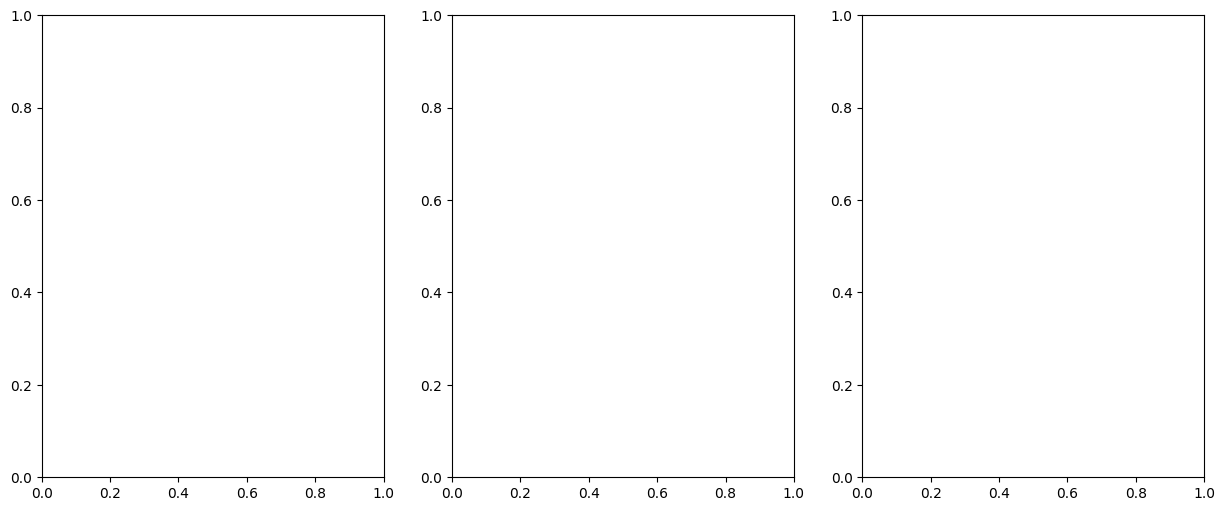

In [10]:
dataset_arr = ['pereira', 'fedorenko', 'blank']
feature_extraction_arr = ['', '-sp', '-mp']

for dataset in dataset_arr:
    
    if dataset == 'pereira':
        
        exp_arr = ['243', '384']
    else:
        
        exp_arr = ['']
        
    fig, ax = plt.subplots(1,3,figsize=(15,6))
        
    for i, fe in enumerate(feature_extraction_arr):
        
            
        print(dataset)
        banded_gpt2_OASM = {'perf': [], 'Model': [], 'Network': [], 'subjects': []}

        for exp in exp_arr:
        
            if len(exp) > 0:
                bl = best_layer_gpt2[f"{dataset}_{exp}_out_of_sample_r2_shuffled_ridge{fe}"]
                bs = best_sigma[f"{dataset}_{exp}_out_of_sample_r2_shuffled_ridge"]
            else:
                bl = best_layer_gpt2[f"{dataset}_out_of_sample_r2_shuffled_ridge{fe}"]
                bs = best_sigma[f"{dataset}_out_of_sample_r2_shuffled_ridge"]
                
            if len(exp) > 0:
            
                banded_model = np.load(f'/data/LLMs/brainscore/results_{dataset}/shuffled/{dataset}_gpt2-xl{fe}_OASM_layer1_1000_{exp}.npz')
                gpt2_model = np.load(f'/data/LLMs/brainscore/results_{dataset}/shuffled/{dataset}_gpt2-xl{fe}_layer_{bl}_1_{exp}.npz')
                OASM_model = np.load(f'/data/LLMs/brainscore/results_{dataset}/shuffled/{dataset}_OASM-all-sigma_{bs}_1_{exp}.npz')
                
            else:
            
                banded_model = np.load(f'/data/LLMs/brainscore/results_{dataset}/shuffled/{dataset}_gpt2-xl{fe}_OASM_layer1_1000.npz')
                gpt2_model = np.load(f'/data/LLMs/brainscore/results_{dataset}/shuffled/{dataset}_gpt2-xl{fe}_layer_{bl}_1.npz')
                OASM_model = np.load(f'/data/LLMs/brainscore/results_{dataset}/shuffled/{dataset}_OASM-all-sigma_{bs}_1.npz')
            
            num_vals = len(banded_model['out_of_sample_r2'])
            
            banded_gpt2_OASM['perf'].extend(np.maximum(banded_model['out_of_sample_r2'],gpt2_model['out_of_sample_r2']))
            banded_gpt2_OASM['perf'].extend(gpt2_model['out_of_sample_r2'])
            banded_gpt2_OASM['perf'].extend(OASM_model['out_of_sample_r2'])
            
            banded_gpt2_OASM['Model'].extend(np.repeat('Banded', num_vals))
            banded_gpt2_OASM['Model'].extend(np.repeat(f'GPT2{fe}', num_vals))
            banded_gpt2_OASM['Model'].extend(np.repeat('OASM', num_vals))
            
            if dataset == 'pereira':
                banded_gpt2_OASM['Network'].extend(np.tile(br_labels_dict[exp],3))
                banded_gpt2_OASM['subjects'].extend(np.tile(subjects_dict[exp],3))
                
            elif dataset == 'fedorenko':
                banded_gpt2_OASM['Network'].extend(np.tile(['language'], num_vals*3))
                banded_gpt2_OASM['subjects'].extend(np.tile(subjects_arr_fed, 3))
                
            else:
                banded_gpt2_OASM['Network'].extend(np.tile(['language'], num_vals*3))
                banded_gpt2_OASM['subjects'].extend(np.tile(subjects_arr_blank,3))
                
        
        banded_gpt2_OASM_pd = pd.DataFrame(banded_gpt2_OASM)

        plot_across_subjects(banded_gpt2_OASM_pd, dataset=dataset, selected_networks=['language'], figurePath=None, clip_zero=True, ms=10, 
                            ylabel_str='', median=False, line_extend=0.05, draw_lines=False, ax_select=ax[i], hue_order=['OASM', 'Banded', f'GPT2{fe}'])
        
        ax[0].set_yticks((0, round(float(ax[0].get_ylim()[1]),2)))
        ax[0].set_yticklabels((0, round(float(ax[0].get_ylim()[1]),2)), fontsize=30)

        ax[1].spines['left'].set_visible(False)   # Hide the left spine
        ax[1].yaxis.set_visible(False)            # Hide the y-axis
        ax[1].set_yticks([])                      # Remove yticks
        ax[1].set_yticklabels([]) 
        ax[2].spines['left'].set_visible(False)   # Hide the left spine
        ax[2].yaxis.set_visible(False)            # Hide the y-axis
        ax[2].set_yticks([])                      # Remove yticks
        ax[2].set_yticklabels([]) 
        
    fig.savefig(f"/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures/new_figures/figure2/banded/{dataset}_banded", dpi=300, bbox_inches='tight')
    fig.savefig(f"/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures/new_figures/figure2/banded/{dataset}_banded.pdf", bbox_inches='tight')
    
    plt.show()

In [7]:
perf_arr = ['out_of_sample_r2', 'pearson_r']
shuffled_arr = ['shuffled', '']
dataset_arr = ['pereira', 'fedorenko', 'blank']

layer_pd_dict = {}
for dataset in dataset_arr:
    
    layer_perf_pd_all = {'perf': [], 'type': [], 'Model': [], 'Shuffled': [], 'layer_num': []}
    
    if dataset == 'pereira':
        
        exp_arr = ['243', '384']
        
    else:
        
        exp_arr = ['']
        
    for perf in perf_arr: 
        
        for i, fe in enumerate(feature_extraction_arr):
            
            for shuffled in shuffled_arr:
        
                for l in range(49):
                                
                    layer_perf_pd = {'perf': [], 'subjects': [], 'Network': []}
                    
                    for exp in exp_arr:
                        
                        if len(exp) > 0:
                            layer_perf =  np.load(f'/data/LLMs/brainscore/results_{dataset}/{shuffled}/{dataset}_gpt2-xl{fe}_layer_{l}_1_{exp}.npz')[perf]
                        else:
                            layer_perf =  np.load(f'/data/LLMs/brainscore/results_{dataset}/{shuffled}/{dataset}_gpt2-xl{fe}_layer_{l}_1.npz')[perf]
                            
                            
                        if perf == 'out_of_sample_r2':
                            layer_perf = np.clip(layer_perf, 0, np.inf)
                            
                        num_vals = len(layer_perf)
                        
                        layer_perf_pd['perf'].extend(layer_perf)
                        
                        if dataset == 'pereira':
                            layer_perf_pd['Network'].extend(br_labels_dict[exp])
                            layer_perf_pd['subjects'].extend(subjects_dict[exp])
                            
                        elif dataset == 'fedorenko':
                            layer_perf_pd['Network'].extend(np.tile(['language'], num_vals))
                            layer_perf_pd ['subjects'].extend(subjects_arr_fed)
                            
                        else:
                            layer_perf_pd['Network'].extend(np.tile(['language'], num_vals))
                            layer_perf_pd['subjects'].extend(subjects_arr_blank)
                            
                    
                    layer_perf_pd = pd.DataFrame(layer_perf_pd)
                    layer_perf_pd = layer_perf_pd.loc[layer_perf_pd.Network=='language']
                    
                    perf_avg = np.median(layer_perf_pd.groupby(['subjects'])['perf'].median())
                    perf_avg_mean = np.mean(layer_perf_pd.groupby(['subjects'])['perf'].median())
                        
                    layer_perf_pd_all['perf'].extend([perf_avg, perf_avg_mean])
                    layer_perf_pd_all['type'].extend(['median', 'mean'])
                    layer_perf_pd_all['Model'].extend([f"GPT2-XL{fe}", f"GPT2-XL{fe}"])
                    layer_perf_pd_all['Shuffled'].extend([f"{shuffled}", f"{shuffled}"])
                    layer_perf_pd_all['layer_num'].extend([f"{l}", f"{l}"])
                      
        layer_pd_dict[f"{dataset}_{perf}"] = pd.DataFrame(layer_perf_pd_all)  

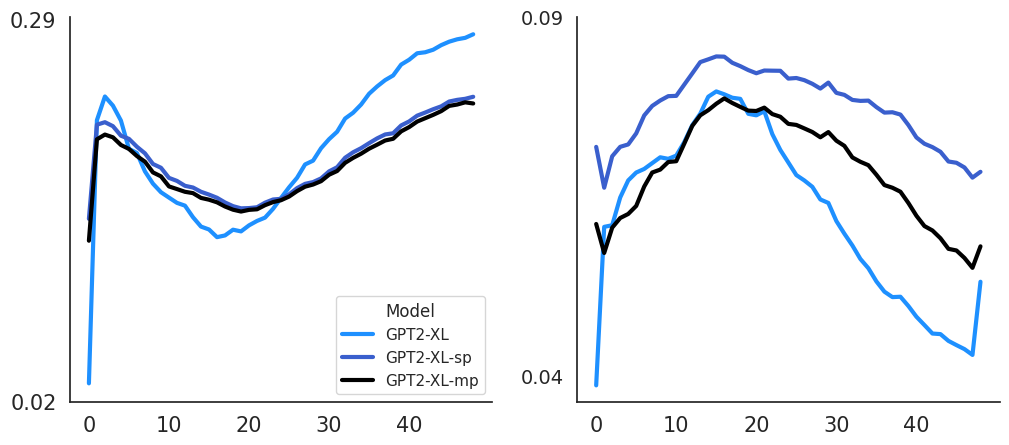

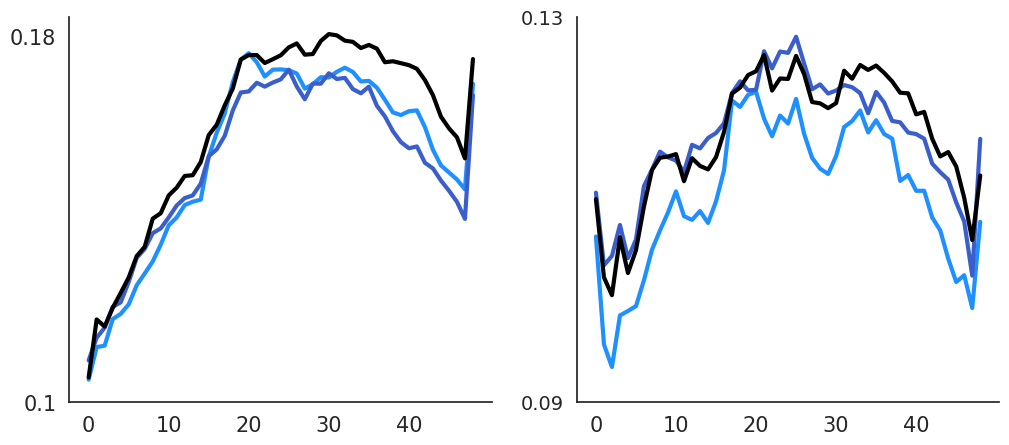

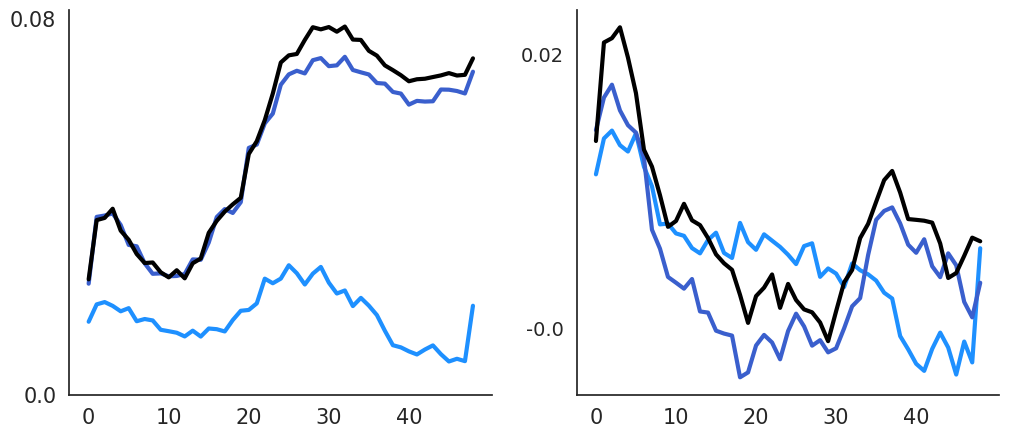

In [13]:
perf_arr = ['pearson_r']
# Create a custom palette with more distinct shades of blue
palette = sns.color_palette(["#1E90FF", "#3A5FCD", 'black'])

c = 0
for perf in perf_arr:
    
    for i, dataset in enumerate(dataset_arr):
        
        fig, ax = plt.subplots(1,2, figsize=(12,5))
        layer_pd_perf_data = layer_pd_dict[f"{dataset}_{perf}"]
    
        layer_perf_pd_all_shuffled = layer_pd_perf_data.loc[layer_pd_perf_data['Shuffled']=='shuffled']
        layer_perf_pd_all_shuffled = layer_perf_pd_all_shuffled.loc[layer_pd_perf_data['type']=='mean']
        
        layer_perf_pd_all = layer_pd_perf_data.loc[layer_pd_perf_data['Shuffled']=='']
        layer_perf_pd_all = layer_perf_pd_all.loc[layer_pd_perf_data['type']=='mean']
        sns.despine()
        
        if c == 0:
            legend = True
        else:
            legend = False
            
        c = 1
            
        sns.lineplot(layer_perf_pd_all_shuffled, x='layer_num', y='perf', hue='Model', errorbar=None, ax=ax[0], legend=legend, linewidth=3, palette=palette)
        sns.lineplot(layer_perf_pd_all, x='layer_num', y='perf', hue='Model', errorbar=None, ax=ax[1], legend=False, linewidth=3, palette=palette)
        
        ax[0].set_xticks([0,10,20,30,40])
        ax[0].set_xticklabels([0,10,20,30,40], fontsize=15)
        
        ax[1].set_xticks([0,10,20,30,40])
        ax[1].set_xticklabels([0,10,20,30,40], fontsize=15)
        ax[0].set_ylabel('')
        ax[0].set_xlabel('')
        ax[1].set_ylabel('')
        ax[1].set_xlabel('')
        
        ax[0].set_yticks((round(float(ax[0].get_ylim()[0]),2), round(float(ax[0].get_ylim()[1]),2)))
        ax[0].set_yticklabels(((round(float(ax[0].get_ylim()[0]),2)), round(float(ax[0].get_ylim()[1]),2)), fontsize=15)
        
        ax[1].set_yticks(((round(float(ax[1].get_ylim()[0]),2), round(float(ax[1].get_ylim()[1]),2))))
        ax[1].set_yticklabels(((round(float(ax[1].get_ylim()[0]),2)), round(float(ax[1].get_ylim()[1]),2)), fontsize=14)
        
    

In [19]:
noL2_str = ''
resultsPath_pereira = f"{resultsPath}results_pereira/"
perf = 'out_of_sample_r2'
dataset = 'pereira'
feature_extraction_methods = ['', '-sp', '-mp']
shuffled_arr = [True, False]

results_dict = {'Model': [], 'shuffled': [], 'Network': [], 'subjects': [], 'perf': [], 'Exp': []}
sigma_values = np.linspace(0.1, 4.8, 48)
for shuffle in shuffled_arr:
    
    if shuffle:
        resultsPath_loop = f"{resultsPath_pereira}shuffled/"
        shuffle_str = 'shuffled'
    else:
        resultsPath_loop = resultsPath_pereira
        shuffle_str = 'contig'
    
    for fe in feature_extraction_methods:
    
        best_results = np.full(shape_pereira_full, fill_value=np.nan)
            
        for network in np.unique(networks_arr_pereira):
    
            network_indices_384 = np.argwhere(br_labels_dict['384'] == network).squeeze()
            network_indices_243 = np.argwhere(br_labels_dict['243'] == network).squeeze()
                
            gpt2_xl_384_dict, gpt2_xl_384_bl, gpt2_xl_384_bl_perf = find_best_layer(np.arange(0,49), noL2_str=noL2_str, exp='_384', 
                                                        resultsPath=resultsPath_loop, selected_network_indices=network_indices_384, dataset=dataset, 
                                                        subjects=subjects_dict['384'], perf=perf, feature_extraction=fe)
            gpt2_xl_243_dict, gpt2_xl_243_bl, gpt2_xl_243_bl_perf = find_best_layer(np.arange(0,49), noL2_str=noL2_str, exp='_243', 
                                                        resultsPath=resultsPath_loop, selected_network_indices=network_indices_243, dataset=dataset, 
                                                        subjects=subjects_dict['243'], perf=perf, feature_extraction=fe)
        


            results_dict['perf'].extend(gpt2_xl_384_bl_perf[network_indices_384])
            results_dict['perf'].extend(gpt2_xl_243_bl_perf[network_indices_243])
            results_dict['Network'].extend(np.repeat(network, len(network_indices_384)))
            results_dict['Network'].extend(np.repeat(network, len(network_indices_243)))
            results_dict['subjects'].extend(subjects_dict['384'][network_indices_384])
            results_dict['subjects'].extend(subjects_dict['243'][network_indices_243])
            results_dict['Model'].extend(np.repeat(f'GPT2-XL{fe}', len(network_indices_384)))
            results_dict['Model'].extend(np.repeat(f'GPT2-XL{fe}', len(network_indices_243)))
            results_dict['shuffled'].extend(np.repeat(shuffle_str, len(network_indices_384)))
            results_dict['shuffled'].extend(np.repeat(shuffle_str, len(network_indices_243)))
            results_dict['Exp'].extend(np.repeat('384', len(network_indices_384)))
            results_dict['Exp'].extend(np.repeat('243', len(network_indices_243)))
            
            
results_dict_pd = pd.DataFrame(results_dict)
results_dict_pd.head()

,Model,shuffled,Network,subjects,perf,Exp
0,GPT2-XL,shuffled,DMN,018,0.160707,384
1,GPT2-XL,shuffled,DMN,018,0.233068,384
2,GPT2-XL,shuffled,DMN,018,0.186691,384
3,GPT2-XL,shuffled,DMN,018,0.224480,384
4,GPT2-XL,shuffled,DMN,018,0.190902,384


Clipping 0 values
Taking mean value across voxels with a participant


/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Clipping 0 values
Taking mean value across voxels with a participant


/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


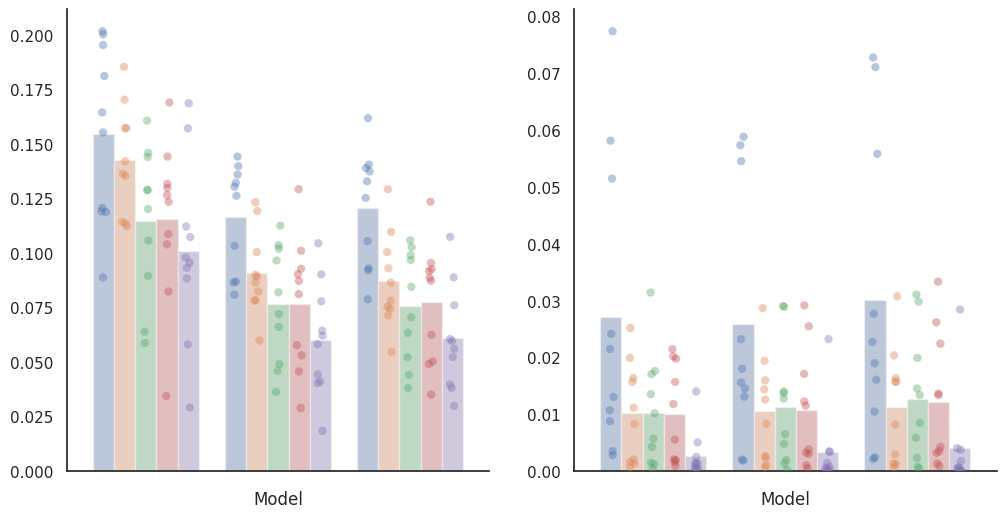

In [20]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
from matplotlib import pyplot as plt
for i, shuffle in enumerate(results_dict_pd.shuffled.unique()):
    
    results_dict_pd_s = results_dict_pd.loc[results_dict_pd.shuffled==shuffle]
    results_dict_pd_s = results_dict_pd_s.drop(axis=1, labels='shuffled')
    yticks=None
    subject_avg_pd, dict_pd_merged, dict_pd_with_all = plot_across_subjects(results_dict_pd_s, None, dataset='pereira', selected_networks=np.unique(networks_arr_pereira), clip_zero=True, plot_legend=False, 
                                                                            ylabel=False, x_var='Model', hue_var='Network', hue_order=['language', 'DMN', 'MD', 'visual', 'auditory'], line_extend=0.04, plot_xlabel=True, yticks=yticks, 
                                                                            ax_select=ax[i], median=False)
    ax[i].set_ylabel('')
    ax[i].set_xticklabels('', fontsize=20)
    
plt.show()



In [33]:
noL2_str = ''
resultsPath_pereira = f"{resultsPath}results_pereira/"
perf = 'out_of_sample_r2'
fe = ''
dataset = 'pereira'

feature_extraction_methods = ['', '-sp', '-mp']
mse_best_layer = {}
ytests_dict = {'pereira': ytest_pereira, 'blank': ytest_blank, 'fedorenko': ytest_fed}
ytests_dict_shuffled = {'pereira': ytest_pereira_shuffled, 'blank': ytest_blank_shuffled, 'fedorenko': ytest_fed_shuffled}
subjects_arr_dict = {'blank': subjects_arr_blank, 'fedorenko': subjects_arr_fed}

for dataset in dataset_arr:
    
    for shuffle in shuffled_arr:  
        if shuffle:
            resultsPath_loop = f"{resultsPath}results_{dataset}/shuffled/"
            shuffle_str = 'shuffled'
            y_test_loop = ytests_dict_shuffled[dataset]
   
        else:
            resultsPath_loop = f"{resultsPath}results_{dataset}/"
            shuffle_str = 'contig'
            y_test_loop = ytests_dict[dataset]
            

        for fe in feature_extraction_methods:
            
            y_hat_full = np.full(shape_pereira_full, fill_value=np.nan)


            if dataset == 'pereira':
                
                for network in np.unique(networks_arr_pereira):
                    
                    network_indices_384 = np.argwhere(br_labels_dict['384']==network).squeeze()
                    network_indices_243 = np.argwhere(br_labels_dict['243']==network).squeeze()
                    
                
                    gpt2_xl_384_dict, gpt2_xl_384_bl, gpt2_xl_384_bl_perf = find_best_layer(np.arange(0,49), noL2_str=noL2_str, exp='_384', 
                                                                        resultsPath=resultsPath_loop, selected_network_indices=network_indices_384, dataset=dataset, 
                                                                        subjects=subjects_dict['384'], perf=perf, feature_extraction=fe)
                    gpt2_xl_243_dict, gpt2_xl_243_bl, gpt2_xl_243_bl_perf = find_best_layer(np.arange(0,49), noL2_str=noL2_str, exp='_243', 
                                                                resultsPath=resultsPath_loop, selected_network_indices=network_indices_243, dataset=dataset, 
                                                                subjects=subjects_dict['243'], perf=perf, feature_extraction=fe)
                    
                
                    best_layer_384 = max(gpt2_xl_384_dict[1], key=gpt2_xl_384_dict[1].get)
                    best_layer_243 = max(gpt2_xl_243_dict[1], key=gpt2_xl_243_dict[1].get)
                    
                    y_hat_384 = np.load(f"{resultsPath_loop}{dataset}_gpt2-xl{fe}_layer_{best_layer_384}_1_384.npz")['y_hat']
                    y_hat_243 = np.load(f"{resultsPath_loop}{dataset}_gpt2-xl{fe}_layer_{best_layer_243}_1_243.npz")['y_hat']
                    
                    y_hat_384[:, ~network_indices_384] = np.nan
                    y_hat_243[:, ~network_indices_243] = np.nan
                    
            
                    y_hat_full[:243, non_nan_indices_243] = y_hat_243
                    y_hat_full[243:, non_nan_indices_384] = y_hat_384
                    
                
                mse_best_layer[f"{dataset}_{shuffle_str}_{fe}"] = (y_test_loop-y_hat_full)**2
                
            else:
            
                gpt2_xl_dict, gpt2_xl_bl, gpt2_xl_bl_perf = find_best_layer(np.arange(0,49), noL2_str=noL2_str, exp='', 
                                                subjects=subjects_arr_dict[dataset], resultsPath=resultsPath_loop, dataset=dataset, perf=perf, feature_extraction=fe)
                
                best_layer = max(gpt2_xl_dict[1], key=gpt2_xl_dict[1].get)
                
              
                y_hat = np.load(f"{resultsPath_loop}{dataset}_gpt2-xl{fe}_layer_{best_layer}_1.npz")['y_hat']
         
                
                mse_best_layer[f"{dataset}_{shuffle_str}_{fe}"] = (y_test_loop-y_hat)**2

In [68]:
store_subject_network_idxs_384 = {}
store_subject_network_idxs_243 = {}
mse_subject_network_best_layer = {}
mse_subject_network_intercept = {}

from scipy.stats import ttest_rel


pvalues_pereira = {'fe': [], 'network': [], 'subject': [], 'pval': [], 'pval_orig': [], 'shuffled': []}

subjects_arr = np.unique(subjects_arr_pereira)
networks_arr = np.unique(networks_arr_pereira)
shuffled_arr = [False, True]
exp = ['both']

for shuffle in shuffled_arr:
    
    if shuffle:
        shuffle_str = 'shuffled'
        mse_intercept_loop = mse_intercept_pereira_full_shuffled
        #mse_intercept_243_loop = mse_intercept_243_shuffled
        #mse_intercept_384_loop = mse_intercept_384_shuffled
        
    else:
        shuffle_str = 'contig'
        mse_intercept_loop = mse_intercept_pereira_full
        #mse_intercept_243_loop = mse_intercept_243
        #mse_intercept_384_loop = mse_intercept_384
    
    for fe in feature_extraction_methods:
        
        for e in exp:

            mse_best_layer_fe = mse_best_layer[f"{shuffle_str}_{fe}{e}"]
            #mse_best_layer_384 = mse_best_layer[f"{shuffle_str}_{fe}384"]
            #mse_best_layer_243 = mse_best_layer[f"{shuffle_str}_{fe}243"]
            
            for network in networks_arr:
                
                for subject in subjects_arr:
                    
                    subject_idxs = np.argwhere(subjects_arr_pereira==subject)
                    network_idxs = np.argwhere(networks_arr_pereira==network)
                    subject_network_idxs =  list(np.intersect1d(subject_idxs, network_idxs))
                    
                    # do a t-test between the intercept only model and the 
                    stat, pval = ttest_rel(mse_best_layer_fe[:, subject_network_idxs], mse_intercept_loop[:, subject_network_idxs], axis=0, nan_policy='omit', alternative='less')
                    
            
                    #subject_idxs_384 = np.argwhere(subjects_dict['384']==subject)
                    #network_idx_384 = np.argwhere(br_labels_dict['384']==network)
                    #subject_network_idxs_384 = list(np.intersect1d(subject_idxs_384, network_idx_384))
                    
                    #subject_idxs_243 = np.argwhere(subjects_dict['243']==subject)
                    #network_idx_243 = np.argwhere(br_labels_dict['243']==network)
                    #subject_network_idxs_243 = list(np.intersect1d(subject_idxs_243, network_idx_243))
                    
                    #mse_best_layer_combined = np.vstack((mse_best_layer_243[:, subject_network_idxs_243[0:2]], mse_best_layer_384[:, subject_network_idxs_384[0:2]]))
                    #mse_intercept_combined = np.vstack((mse_intercept_loop_243[:, subject_network_idxs_243[0:2]], mse_intercept_loop_384[:, subject_network_idxs_384[0:2]]))
                    
                    #stat, pval2 = ttest_rel(mse_best_layer_combined, mse_intercept_combined, axis=0, nan_policy='omit', alternative='less')
                    
                    
                    pval = pval[~np.isnan(pval)]
                    
                    pval_fdr = false_discovery_control(pval, method='bh')
                    
                    pvalues_pereira['pval'].extend(pval_fdr)
                    pvalues_pereira['pval_orig'].extend(pval)
                    pvalues_pereira['subject'].extend(np.repeat(subject,len(pval)))
                    pvalues_pereira['network'].extend(np.repeat(network,len(pval)))
                    pvalues_pereira['shuffled'].extend(np.repeat(shuffle_str,len(pval)))
                    
                    if len(fe) == 0:
                        fe_name = '-lt'
                    else:
                        fe_name = fe
                        
                    pvalues_pereira['fe'].extend(np.repeat(fe_name,len(pval)))
                    
                    
pvalues_pereira = pd.DataFrame(pvalues_pereira)

/tmp/ipykernel_3042761/3357384490.py:47: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  stat, pval = ttest_rel(mse_best_layer_fe[:, subject_network_idxs], mse_intercept_loop[:, subject_network_idxs], axis=0, nan_policy='omit', alternative='less')


In [118]:
pvalues_pereira.to_csv('figures_data/pvalues_pereira.csv', index=False)

In [14]:
pvalues_pereira = pd.read_csv('figures_data/pvalues_pereira.csv')

/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


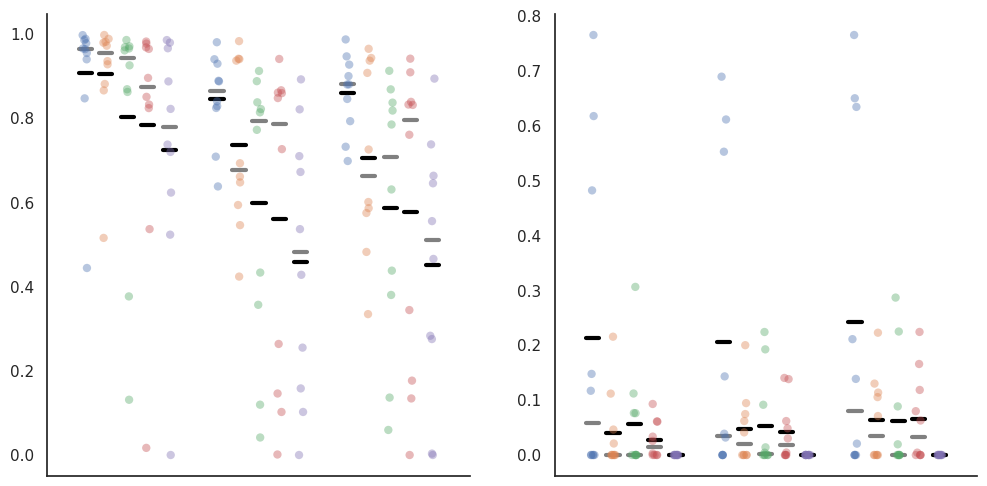

In [15]:
shuffled_str_arr = ['shuffled', 'contig']
pvals_arr = ['pval']

fig, ax = plt.subplots(1,2, figsize=(12,6))

for i, shuffle_str in enumerate(shuffled_str_arr):
    
    for j, pval in enumerate(pvals_arr):
        
        pvalues_pereira_loop = pvalues_pereira.loc[pvalues_pereira.shuffled==shuffle_str]
        
        # Group by 'network' and calculate fraction of p-values under 0.05
        fraction_under_005_fdr = pvalues_pereira_loop.groupby(['subject', 'network', 'fe'])['pval'].apply(lambda x: (x < 0.05).mean()).reset_index()
        
        fraction_under_005_fdr = fraction_under_005_fdr.rename(columns={'pval': 'perf', 'network': 'Network', 'fe': 'Model'})

        plot_across_subjects(subject_avg_pd=fraction_under_005_fdr.reset_index(), hue_var='Network', x_var='Model', dict_pd_merged=None, figurePath=None, dataset='pereira', 
                            selected_networks=['language', 'DMN', 'MD', 'visual', 'auditory'], line_extend=0.05, hue_order=['language', 'DMN', 'MD', 'visual', 'auditory'], 
                            ylabel_str='', plot_legend=False, ax_select=ax[i])

plt.show()

In [52]:
store_subject_network_idxs_384 = {}
store_subject_network_idxs_243 = {}
mse_subject_network_best_layer = {}
mse_subject_network_intercept = {}

from scipy.stats import ttest_rel

network = 'language'

for dataset in ['blank']:
    
    pvalues_pd = {'fe': [], 'subject': [], 'pval': [], 'pval_orig': [], 'shuffled': [], 'network': []}
    
    if dataset == 'fedorenko':
        subjects_arr = subjects_arr_fed
    else:
        subjects_arr = subjects_arr_blank

    for shuffle in shuffled_arr:
        
        if shuffle:
            shuffle_str = 'shuffled'
            
            if dataset == 'blank':
                mse_intercept_loop = mse_intercept_blank_shuffled
            else:
                mse_intercept_loop = mse_intercept_fed_shuffled
            
        else:
            shuffle_str = 'contig'
            
            if dataset == 'blank':
                mse_intercept_loop = mse_intercept_blank
            else:
                mse_intercept_loop = mse_intercept_fed
                
        for fe in feature_extraction_methods:

            mse_best_layer_fe = mse_best_layer[f"{dataset}_{shuffle_str}_{fe}"]

            for subject in np.unique(subjects_arr):
                    
                subject_idxs = np.argwhere(subjects_arr==subject)
                
                # do a t-test between the intercept only model and the 
                stat, pval = ttest_rel(mse_best_layer_fe[:,  subject_idxs], mse_intercept_loop[:, subject_idxs], axis=0, nan_policy='omit', alternative='less')
                
    
                pval = pval[~np.isnan(pval)]
                
                pval_fdr = false_discovery_control(pval, method='bh')
                
                pvalues_pd['pval'].extend(pval_fdr)
                pvalues_pd['pval_orig'].extend(pval)
                pvalues_pd['subject'].extend(np.repeat(subject,len(pval)))
                pvalues_pd['network'].extend(np.repeat(network,len(pval)))
                pvalues_pd['shuffled'].extend(np.repeat(shuffle_str,len(pval)))
                
                if len(fe) == 0:
                    fe_name = '-lt'
                else:
                    fe_name = fe
                    
                pvalues_pd['fe'].extend(np.repeat(fe_name,len(pval)))
                
                    
pvalues_pd = pd.DataFrame(pvalues_pd)

/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/shape_base.py:65: UserWarning: Warning: converting a masked element to nan.
  ary = asanyarray(ary)
/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/shape_base.py:65: UserWarning: Warning: converting a masked element to nan.
  ary = asanyarray(ary)


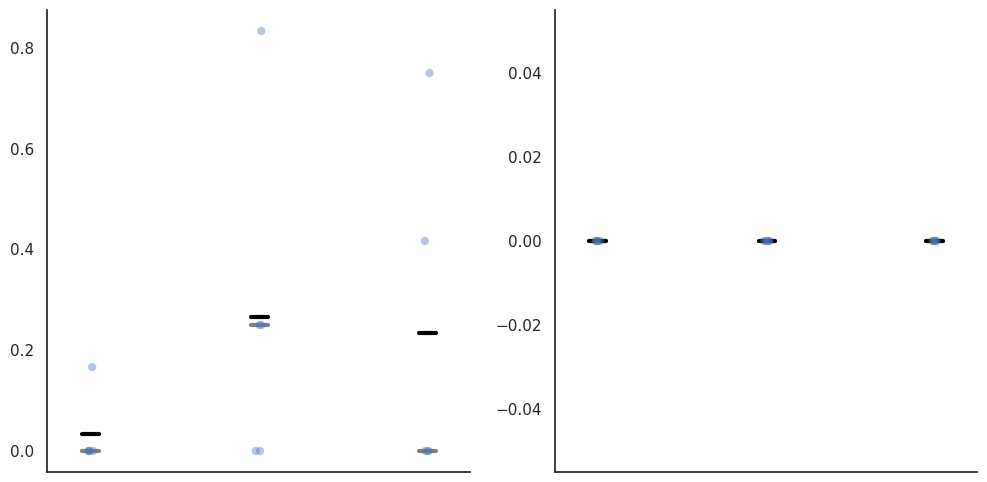

In [56]:
shuffled_str_arr = ['shuffled', 'contig']
pvals_arr = ['pval']

fig, ax = plt.subplots(1,2, figsize=(12,6))

for i, shuffle_str in enumerate(shuffled_str_arr):
    
    for j, pval in enumerate(pvals_arr):
        
        pvalues_pd_loop = pvalues_pd.loc[pvalues_pd.shuffled==shuffle_str]
        
        # Group by 'network' and calculate fraction of p-values under 0.05
        fraction_under_005_fdr = pvalues_pd_loop.groupby(['subject', 'network', 'fe'])['pval'].apply(lambda x: (x < 0.05).mean()).reset_index()
        
        fraction_under_005_fdr = fraction_under_005_fdr.rename(columns={'pval': 'perf', 'network': 'Network', 'fe': 'Model'})

        plot_across_subjects(subject_avg_pd=fraction_under_005_fdr.reset_index(), hue_var='Network', x_var='Model', dict_pd_merged=None, figurePath=None, dataset='pereira', 
                            selected_networks=['language', 'DMN', 'MD', 'visual', 'auditory'], line_extend=0.05, hue_order=['language', 'DMN', 'MD', 'visual', 'auditory'], 
                            ylabel_str='', plot_legend=False, ax_select=ax[i])

plt.show()

<Axes: xlabel='shuffled', ylabel='pval'>

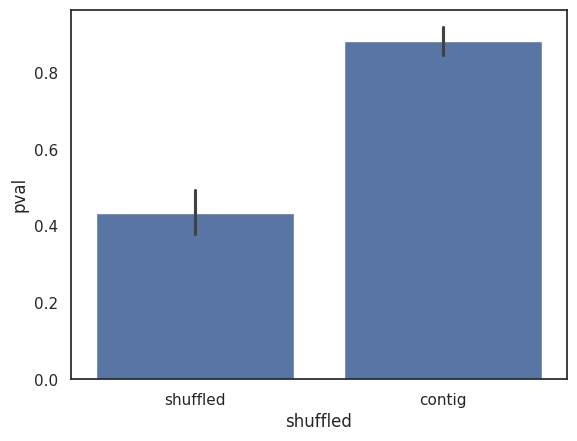

In [54]:
sns.barplot(pvalues_pd, x='shuffled', y='pval')